In [1]:
import pandas as pd 
import numpy as np 

In [5]:
df = pd.read_csv(r'C:\Users\hp\Downloads\Anomaly-Detection-SocialMedia\test\data\Tweets.csv')
df.head()

,textID,text,selected_text,sentiment
0,cb774db0d1,"I`d have responded, if I were going","I`d have responded, if I were going",neutral
1,549e992a42,Sooo SAD I will miss you here in San Diego!!!,Sooo SAD,negative
2,088c60f138,my boss is bullying me...,bullying me,negative
3,9642c003ef,what interview! leave me alone,leave me alone,negative
4,358bd9e861,"Sons of ****, why couldn`t they put them on t...","Sons of ****,",negative


In [6]:
df.drop(['selected_text', 'textID'], axis=1, inplace=True)

In [7]:
df.head()

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [8]:
df.reset_index(drop=True, inplace=True)


In [9]:
original_df = df.copy(deep=True) # Any changes you make to original_df 
                                 # (like adding/removing rows, altering values, etc.) will not 
                                 # affect the original DataFrame df.
display(df.head())

,text,sentiment
0,"I`d have responded, if I were going",neutral
1,Sooo SAD I will miss you here in San Diego!!!,negative
2,my boss is bullying me...,negative
3,what interview! leave me alone,negative
4,"Sons of ****, why couldn`t they put them on t...",negative


In [ ]:
print('\n\033[1mInference:\033[0m The Datset consists of {} features & {} samples.'.format(df.shape[1], df.shape[0]))

             # ANSI escape code : "\033" is the escape character / [1m is the code for bold text..


Inference: The Datset consists of 2 features & 27481 samples.


In [12]:
df.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27481 entries, 0 to 27480
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   text       27480 non-null  object
 1   sentiment  27481 non-null  object
dtypes: object(2)
memory usage: 429.5+ KB


In [13]:
display(df.describe())


,text,sentiment
count,27480,27481
unique,27480,3
top,"I`d have responded, if I were going",neutral
freq,1,11118


In [15]:
df.isnull().sum()


text         1
sentiment    0
dtype: int64

In [16]:
df.dropna(inplace=True)

In [17]:
df.isnull().sum()


text         0
sentiment    0
dtype: int64

In [18]:
# Checking for duplicate rows
duplicate_rows = df.duplicated()
print(f"Number of duplicate rows: {duplicate_rows.sum()}")

Number of duplicate rows: 0


In [19]:
import nltk                 # for tokenization, stemming, tagging, parsing
import string               # for text cleaning , removing punctuation 
from tqdm import tqdm       # for adding progress bars to your loops // monitor the progress.
from multiprocessing import Pool     #  for parallel processing // by utilizing multiple CPU cores.
from nltk.corpus import stopwords    #  lists of stopwords
from nltk.stem.porter import PorterStemmer # stemming algorithm , reduces words to their root form.(running run)

In [ ]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\hp\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [23]:
tqdm.pandas()

def preprocessor(text):
    text = text.lower()     # convert text to lowercase
    text = ''.join([i for i in text if i in string.ascii_lowercase+' '])   # non-letter characters (except spaces)
    text = ' '.join([PorterStemmer().stem(word) for word in text.split()])  # stemming  
    text = ' '.join([word for word in text.split() if word not in stopwords.words('english')]) # remove stopwords
    return text

#with Pool(4) as p:
#    df['text'] = list(tqdm(p.imap(preprocessor, range(df.shape[0]))))
df['text'] = df['text'].progress_apply(preprocessor)

df.head()

100%|██████████| 27480/27480 [01:19<00:00, 345.36it/s]


,text,sentiment
0,id respond go,neutral
1,sooo sad miss san diego,negative
2,boss bulli,negative
3,interview leav alon,negative
4,son whi couldnt put relea alreadi bought,negative


In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer
from nltk.stem.porter import PorterStemmer

# PorterStemmer
porter = PorterStemmer()

# tokenizer functions
def tokenizer(text):
    return text.split()

def tokenizer_porter(text):
    # stemming to each word
    return [porter.stem(word) for word in text.split()]

# initialize TfidfVectorizer with the custom tokenizer
tfidf = TfidfVectorizer(
    strip_accents='unicode',  # normalize accents 
    lowercase=True,           # convert to lowercase to ensure consistency
    preprocessor=None,        # already did preprocessing,  don't need this
    tokenizer=tokenizer_porter,  # use PorterStemmer tokenizer
    use_idf=True,             # use inverse document frequency
    norm='l2',                # normalize by the L2 norm
    smooth_idf=True           # smooth IDF
)


In [26]:
target = df['sentiment']

y = target.values  # target labels (sentiment)
x = tfidf.fit_transform(df['text'])  # TF-IDF matrix for the 'text' column

c:\Users\hp\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\feature_extraction\text.py:525: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


            Target Variable Distribution           


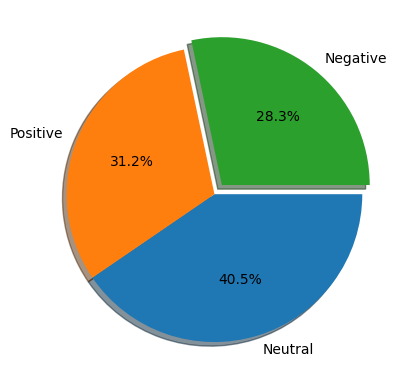

In [29]:
import matplotlib.pyplot as plt

# Plot the distribution of target variable
print('\033[1mTarget Variable Distribution'.center(55))
plt.pie(target.value_counts(), labels=['Neutral', 'Positive', 'Negative'], counterclock=False, shadow=True,
        explode=[0, 0, 0.08], autopct='%1.1f%%', radius=1, startangle=0)
plt.show()

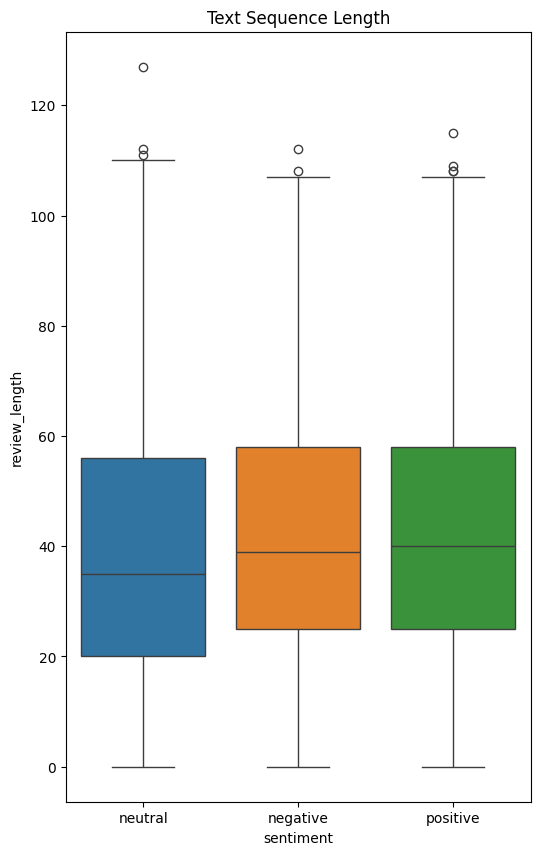

In [31]:
import seaborn as sns

# Create a copy of df to calculate the text length
df2 = df.copy()

# Calculate the text length for each review
df2['review_length'] = df2['text'].apply(len)

# Visualize the average text sequence length using a boxplot
plt.figure(figsize=[6,10])
sns.boxplot(x=target, y='review_length', data=df2, hue=target)
plt.title('Text Sequence Length')
plt.show()

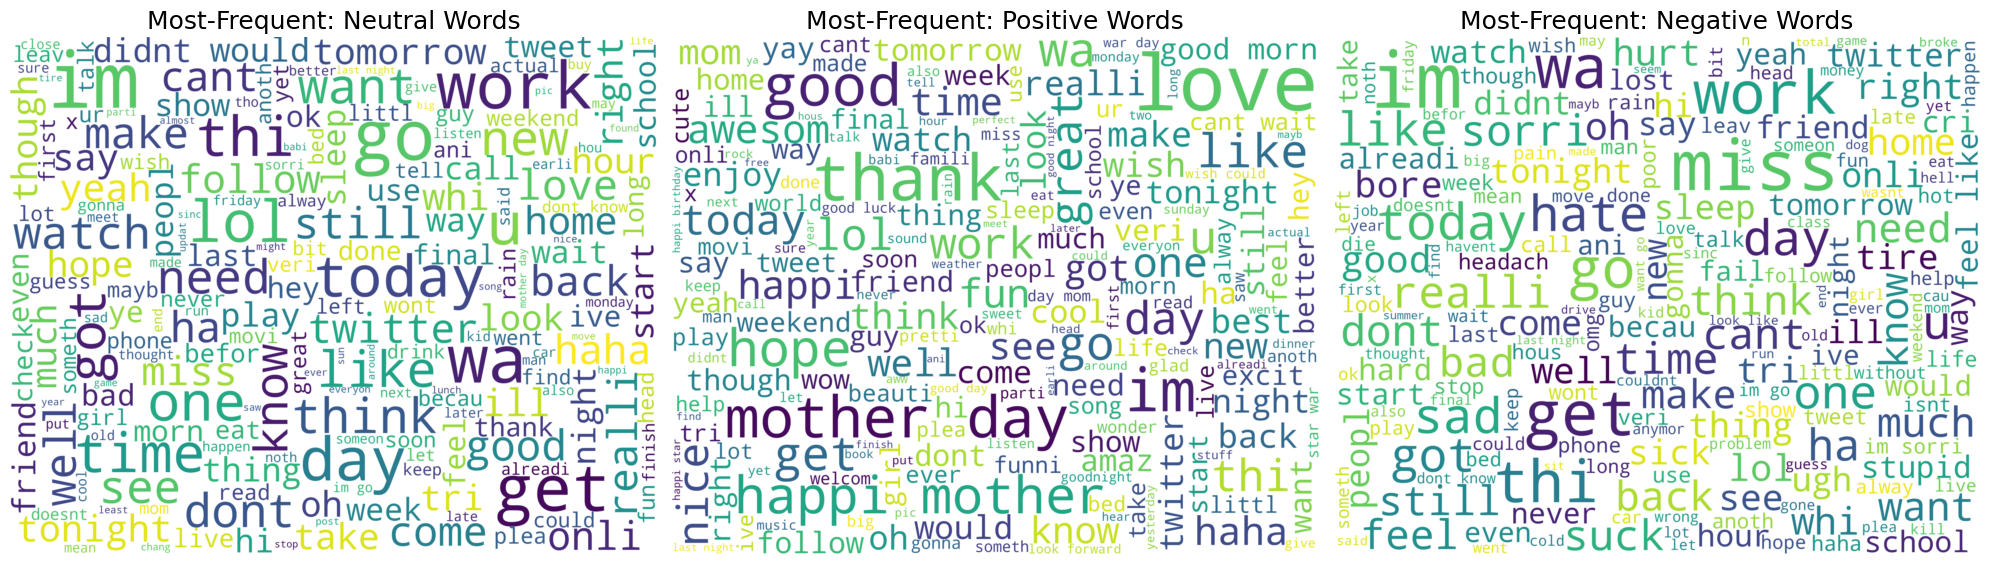

In [34]:
from wordcloud import WordCloud

# splitting the original DataFrame based on sentiment
neutraldata = df[df['sentiment'] == 'neutral']['text']
positivedata = df[df['sentiment'] == 'positive']['text']
negdata = df[df['sentiment'] == 'negative']['text']

# function to generate and plot WordCloud
def wordcloud_draw(data, color, s):
    words = ' '.join(data)
    cleaned_words = " ".join([word for word in words.split() if word.lower() not in ['movie', 'film']])
    
    # generate word cloud
    wordcloud = WordCloud(stopwords=stopwords.words('english'),
                          background_color=color,
                          width=2500, height=2000,
                          max_font_size=300,
                          random_state=42).generate(cleaned_words)
    
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(s, fontsize=18)
    plt.axis('off')

# plotting the word clouds
plt.figure(figsize=(20, 10))

# neutral Word Cloud
plt.subplot(1, 3, 1)
wordcloud_draw(neutraldata, 'white', 'Most-Frequent: Neutral Words')

# positive Word Cloud
plt.subplot(1, 3, 2)
wordcloud_draw(positivedata, 'white', 'Most-Frequent: Positive Words')

# negative Word Cloud
plt.subplot(1, 3, 3)
wordcloud_draw(negdata, 'white', 'Most-Frequent: Negative Words')

plt.tight_layout()
plt.show()

In [33]:
df.head()

,text,sentiment
0,id respond go,neutral
1,sooo sad miss san diego,negative
2,boss bulli,negative
3,interview leav alon,negative
4,son whi couldnt put relea alreadi bought,negative


In [35]:
MAP={'negative':0, 'neutral':1, 'positive':2}
df.sentiment = df.sentiment.map(MAP)

In [36]:
from sklearn.model_selection import train_test_split

# splitting the data intro training & testing sets

X = x       # TF-IDF transformed features
Y = df['sentiment']   # already mapped to numerical values
Train_X, Test_X, Train_Y, Test_Y = train_test_split(X, Y, train_size=0.8, test_size=0.2, random_state=0)

# displaying the results

print('Original set  ---> ', X.shape, len(Y))
print('Training set  ---> ', Train_X.shape, len(Train_Y))
print('Testing set   ---> ', Test_X.shape, len(Test_Y))     

Original set  --->  (27480, 22569) 27480
Training set  --->  (21984, 22569) 21984
Testing set   --->  (5496, 22569) 5496


In [37]:
# creating a df to store the evaluation results of various models
Evaluation_Results = pd.DataFrame(
    np.zeros((4, 5)), 
    columns=['Accuracy', 'Precision', 'Recall', 'F1-score', 'AUC-ROC score']
)

# naming the rows for each model
Evaluation_Results.index = [
    'Logistic Regression (LR)', 
    'Decision Tree Classifier (DT)', 
    'Random Forest Classifier (RF)', 
    'Naïve Bayes Classifier (NB)'
]

# display the initial table
print("Initialized Evaluation Table:")
display(Evaluation_Results)

Initialized Evaluation Table:


,Accuracy,Precision,Recall,F1-score,AUC-ROC score
Logistic Regression (LR),0.0,0.0,0.0,0.0,0.0
Decision Tree Classifier (DT),0.0,0.0,0.0,0.0,0.0
Random Forest Classifier (RF),0.0,0.0,0.0,0.0,0.0
Naïve Bayes Classifier (NB),0.0,0.0,0.0,0.0,0.0


In [ ]:
from scikitplot.estimators import plot_feature_importances
from scikitplot.metrics import plot_confusion_matrix, plot_roc



ModuleNotFoundError: No module named 'scikitplot'